In this project, we aim to analyse USA air quality data available for the past 27 years. This dataset contains 
daily concentration levels of various air pollutants from monitoring stations located at various locations throughout the United States. We have performed 
Exploratory Data Analysis on this dataset and have made the following analysis for each of Carbon Monoxide, Ozone, PM 2.5 and PM 10
concentrations available:
    1. Top 10 States with the highest and lowest average concentration in the 5 year period from 2013 - 2017
    2. Yearly trend in the average concentration levels for the United States
    3. Heatmap summarising the average concentration levels yearwise for every state.
    4. Geospatial representation of CO concentration and CO Air quality Index.
    5. Feature correlation between NO2, SO2, CO, O3 and PM 2.5

#### Importing required libraries

In [1]:
from pyspark.sql import DataFrame
from pyspark.rdd import RDD
from pyspark.sql.functions import *
from pyspark import SparkConf, SparkContext
import matplotlib.pyplot as plt
import seaborn as sns
conf = (SparkConf()
        .setAppName("mdsr11"))
sc = SparkContext.getOrCreate(conf = conf)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
122,application_1574881784974_0040,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


#### Loading data into Spark Dataframes

In [2]:
co = spark.read.option("inferSchema", True).csv("co.csv",header=True,sep=",")
# o3 = spark.read.option("inferSchema", True).csv("o3.csv",header=True,sep=",")
# no2 = spark.read.option("inferSchema", True).csv("no2.csv",header=True,sep=",")
# pm25 = spark.read.option("inferSchema", True).csv("pm25_frm.csv",header=True,sep=",")
# so = spark.read.option("inferSchema", True).csv("so2.csv",header=True,sep=",")

In [3]:
co.printSchema()

root
 |-- state_code: integer (nullable = true)
 |-- county_code: integer (nullable = true)
 |-- site_num: integer (nullable = true)
 |-- parameter_code: integer (nullable = true)
 |-- poc: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- datum: string (nullable = true)
 |-- parameter_name: string (nullable = true)
 |-- sample_duration: string (nullable = true)
 |-- pollutant_standard: string (nullable = true)
 |-- date_local: timestamp (nullable = true)
 |-- units_of_measure: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- observation_count: integer (nullable = true)
 |-- observation_percent: integer (nullable = true)
 |-- arithmetic_mean: double (nullable = true)
 |-- first_max_value: double (nullable = true)
 |-- first_max_hour: integer (nullable = true)
 |-- aqi: double (nullable = true)
 |-- method_code: double (nullable = true)
 |-- method_name: string (nullable = true)
 |-- local_site_name: st

### CO concentration

In [4]:
#extracting year, month and day from date
co_modified = co.withColumn("Year",year(co["date_local"])).withColumn("Month",month(co["date_local"])) \
                .withColumn("day",dayofmonth(co["date_local"])).withColumn("week_num",weekofyear(co["date_local"]))
co_yearly = co_modified.groupBy("state_name","Year").agg(mean("arithmetic_mean").alias("Yearly average")) 
co_yearly.describe().show()                                                            

+-------+----------+------------------+-------------------+
|summary|state_name|              Year|     Yearly average|
+-------+----------+------------------+-------------------+
|  count|      1424|              1424|               1424|
|   mean|      null|2003.6678370786517| 0.6281618258480989|
| stddev|      null|  8.10073120504324| 0.3926821416637076|
|    min|   Alabama|              1990|0.07981991411042953|
|    max|   Wyoming|              2017| 2.4703099871794874|
+-------+----------+------------------+-------------------+

In [5]:
co_modified.agg({"Year": "max"}).collect()[0]

Row(max(Year)=2017)

In [6]:
co_past_5_years = co_modified.filter(co_modified.Year>2012)

In [7]:
mean_df = co_past_5_years.select("Year","Month","day","week_num","state_code","county_code","arithmetic_mean","state_name","county_name")
mean_df.show()

+----+-----+---+--------+----------+-----------+-------------------+------------+-----------+
|Year|Month|day|week_num|state_code|county_code|    arithmetic_mean|  state_name|county_name|
+----+-----+---+--------+----------+-----------+-------------------+------------+-----------+
|2016|    8|  7|      31|        56|         39|           0.212292|     Wyoming|      Teton|
|2014|    8| 13|      33|        31|         55|           0.866667|    Nebraska|    Douglas|
|2016|    3|  3|       9|        44|          7|                0.2|Rhode Island| Providence|
|2017|    8| 28|      35|        40|        143|            0.10625|    Oklahoma|      Tulsa|
|2016|    8| 14|      32|        40|        109|           0.191667|    Oklahoma|   Oklahoma|
|2016|   11| 24|      47|        40|        109|              0.325|    Oklahoma|   Oklahoma|
|2016|   10| 11|      41|        48|        309|              0.225|       Texas|   McLennan|
|2017|    5| 21|      20|        48|        245|            

In [8]:
county_monthly = mean_df.groupby("county_name","Month","Year").agg(mean("arithmetic_mean").alias("monthly_mean"))

In [9]:
county_monthly.show()

+--------------------+-----+----+--------------------+
|         county_name|Month|Year|        monthly_mean|
+--------------------+-----+----+--------------------+
|               Clark|    1|2015|  0.8389536098901101|
|              Fulton|    3|2013|  0.3166239032258065|
|            Pinellas|    3|2014| 0.27301603225806453|
|      San Bernardino|    5|2016| 0.30434241935483874|
|      San Bernardino|    9|2013| 0.25566324999999995|
|              Dakota|    7|2015| 0.07184111627906976|
|              Dakota|   12|2016| 0.18464786021505372|
|BAJA CALIFORNIA N...|    5|2013|  0.5902873870967743|
|               Wayne|    2|2017|  0.3983642723214285|
|                Inyo|   11|2016| 0.10341501666666669|
|               Weber|    8|2015|  0.3725197419354839|
|                Inyo|   10|2016| 0.10159172580645164|
|        Contra Costa|   11|2016|  0.3423930888888889|
|             Steuben|    8|2013|  0.1581773387096774|
|            Burleigh|   12|2017| 0.17975704838709675|
|         

In [10]:
monthly_means = county_monthly.groupby("county_name","Month").agg(mean("monthly_mean").alias("monthly_agg"))

In [11]:
pivot_df =  monthly_means.groupby("county_name").pivot("Month").sum("monthly_agg")
pivot_df.show()

+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|    county_name|                  1|                  2|                  3|                  4|                  5|                   6|                  7|                  8|                  9|                 10|                 11|                 12|
+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|           Utah| 0.7908680322580646| 0.5510073263546797|0.40991791411290324|0.27621108000000005|  0.249506870967742| 0.23170236976190478|0.24709246788856304|0.23534667924731184| 0.2423577764102564|0.37421166818687435| 0.56

In [12]:
pivot_df.columns

['county_name', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [25]:
vals = pivot_df.select([i for i in pivot_df.columns[1:]])

In [27]:
vals.show()

+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|                  1|                  2|                  3|                  4|                  5|                   6|                  7|                  8|                  9|                 10|                 11|                 12|
+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| 0.7908680322580646| 0.5510073263546797|0.40991791411290324|0.27621108000000005|  0.249506870967742| 0.23170236976190473|0.24709246788856304|0.23534667924731184| 0.2423577764102564|0.37421166818687424| 0.5661991575177305| 0.8387299653039415|
|0.38015149843292784| 0.3608

In [29]:
vals.dtypes

[('1', 'double'), ('2', 'double'), ('3', 'double'), ('4', 'double'), ('5', 'double'), ('6', 'double'), ('7', 'double'), ('8', 'double'), ('9', 'double'), ('10', 'double'), ('11', 'double'), ('12', 'double')]

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [44]:
pivot_df.columns

['county_name', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [50]:
FEATURES_COL

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [60]:
vals.columns

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [14]:
FEATURES_COL = [x for x in pivot_df.columns[1:]]

In [15]:
for col in pivot_df.columns:
    print(col)
    if col in FEATURES_COL:
        print(col)
        pivot_df= pivot_df.withColumn(col,pivot_df[col].cast('float'))

county_name
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12

In [16]:
pivot_df = pivot_df.na.drop()

In [17]:
vecAssembler = VectorAssembler(inputCols=[x for x in pivot_df.columns[1:]], outputCol="features")

In [76]:
df_kmeans

DataFrame[county_name: string, features: vector]

In [18]:
df_kmeans = vecAssembler.transform(pivot_df).select('county_name', 'features')

In [19]:
df_kmeans.show()

+---------------+--------------------+
|    county_name|            features|
+---------------+--------------------+
|           Utah|[0.79086804389953...|
|          Bucks|[0.15161269903182...|
|      Worcester|[0.38015151023864...|
|          Scott|[0.21572221815586...|
|          Marin|[0.50416028499603...|
|         Monroe|[0.24316269159317...|
|     Litchfield|[0.18295666575431...|
|         Queens|[0.28466057777404...|
|         Marion|[0.39741173386573...|
|Prince George's|[0.27432739734649...|
|           Inyo|[0.10982365906238...|
|       Richland|[0.18966668844223...|
|         Sonoma|[0.51803046464920...|
|       Gallatin|[0.19588682055473...|
|           Napa|[0.60091298818588...|
|       Franklin|[0.29085123538970...|
|         Dallas|[0.27432560920715...|
|         Brooke|[0.31061038374900...|
|     Lackawanna|[0.21580380201339...|
|         DeKalb|[0.33529868721961...|
+---------------+--------------------+
only showing top 20 rows

In [20]:
kmeans = KMeans().setK(12).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
wssse = model.computeCost(df_kmeans)

In [21]:
wssse

5.690241202556729

In [23]:
transformed = model.transform(df_kmeans).select('county_name', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(county_name='Utah', prediction=4), Row(county_name='Bucks', prediction=3), Row(county_name='Worcester', prediction=11)]

In [25]:
df_pred = sqlContext.createDataFrame(rows)
# df_pred.show()
df_pred = df_pred.join(pivot_df, 'county_name')
df_pred.show()


+---------------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+----------+----------+
|    county_name|prediction|         1|         2|         3|          4|          5|          6|          7|         8|          9|         10|        11|        12|
+---------------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+----------+----------+
|          Bucks|         3| 0.1516127|0.26236367|0.18288474| 0.20156944|0.112490386|0.030455017|0.018346773|0.03309963|0.033888865|0.079923384|0.15848973| 0.3308468|
|           Utah|         4|0.79086804|0.55100733|0.40991792| 0.27621108| 0.24950688| 0.23170237| 0.24709247|0.23534667| 0.24235778| 0.37421167| 0.5661992|   0.83873|
|      Worcester|        11| 0.3801515| 0.3608645| 0.3468269|  0.2764137| 0.25746077| 0.23562533| 0.24799682|0.24290577| 0.24491102|  0.2953758| 0.3582062|0.37833712

In [26]:
df_pred.createOrReplaceTempView("v_temp")

In [27]:
%%sql -q -o v_temp
SELECT * from v_temp

[ 3  4 11 10  0  3 10  6  0 10  3 10  3  0  4  6  7  6  7  6  7  7  6  7
 11 11  4  3  3  4  3  0  6 11  9  7  3  0 11  0 10  4  0  6  0  7  8 10
  0 10  4  6  8  0 11  3  6 10  6 11  6 10  0  6  6 10 10  6  3 10  6  6
 11  7  7  7  3  0  0 11 10  4  3  5  0  6 11  6  6  4  7  0 10  6 10 11
  6  6  3 11  8 11  1  7  3  4  3  3  6  4  6  8 10  6  6 11  3 11  3  6
  3  6  4  3 10  6  6  6  3  6 11 11  7  3 11  3 10 10 10  6  3  6  7  3
  3  3 11  3  6  0  8  3  0 10 10  0  0  4  4  7  3  6  2  4 11  3  7  3
  6  6  7  3  3  6  6 10  0  4 10  6  6  0 10]


<Figure size 1440x2880 with 0 Axes>

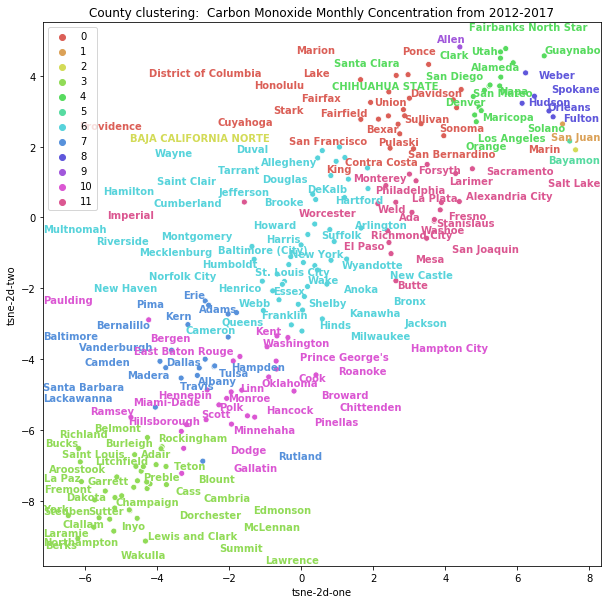

In [71]:
%%local
%matplotlib inline
!pip install adjustText --user
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text
import pandas as pd
import seaborn as sns
data = v_temp[['1','2','3','4','5','6','7','8','9','10','11','12']].values
label = v_temp['prediction'].values
x_tsne_embedded_1 = TSNE(perplexity = 50,n_components = 2,metric='euclidean').fit_transform(data)
x_tsne_embedded_1.shape
print(label)
def plot_tsne(x,label,n_clust,i):
    fig=plt.figure(figsize = (20,40))
    fig.set_size_inches(20,40, forward=True)
    df_subset = pd.DataFrame()
    df_subset['tsne-2d-one'] = x[:,0]
    df_subset['tsne-2d-two'] = x[:,1]
    plt.figure(figsize=(10,10))
#     flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# #     "#9b59b6",
    ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=label,
#     palette = sns.hls_palette(11,l=.3, s=.8),
#     palette = sns.color_palette("cubehelix", 11),
    palette = sns.color_palette("hls",n_clust),
    data=df_subset,
    legend="full",
    alpha=1)
    labelss = {}
    for i in range(x_tsne_embedded_1.shape[0]):
#         if 
#         print(i,x_tsne_embedded_1[0])
        labelss[v_temp['county_name'].values[i]] = [(x_tsne_embedded_1[:,0][i],x_tsne_embedded_1[:,1][i]),sns.color_palette("hls",n_clust)[label[i]]]
#     for label in labelss:
#         print(labelss[label])
#         print(label)
       
    texts = [ plt.annotate(label, 
                 labelss[label][0],
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=10, weight='bold',
                color = labelss[label][1]) for label in labelss]
    adjust_text(texts)
    
    ax.title.set_text('County clustering:  Carbon Monoxide Monthly Concentration from 2012-2017')
plot_tsne(x_tsne_embedded_1,label,12,0)

In [92]:
# sse = []
# clus = []
for i in range(15,25):
    print(i)
    kmeans = KMeans().setK(i).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    wssse = model.computeCost(df_kmeans)
    clus.append(i)
    sse.append(wssse)

15
16
17
18
19
20
21
22
23
24

In [189]:
k = 12
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)


An error was encountered:
Invalid status code '404' from http://data8.cs.rutgers.edu:8999/sessions/120 with error payload: "Session '120' not found."


In [122]:
import numpy as np
corr_mat = np.array(a)

In [123]:
corr_mat

array([[ 2.        ,  3.        ,  4.        ,  5.        ,  6.        ,
         7.        ,  8.        ,  9.        , 10.        , 11.        ,
        12.        , 13.        , 14.        , 15.        , 16.        ,
        17.        , 18.        , 19.        , 20.        , 21.        ,
        22.        , 23.        , 24.        ],
       [44.27255077, 25.36486728, 17.52412593, 12.64669647, 10.88140951,
         8.96537575,  7.93323441,  6.33508479,  6.37479887,  4.96001946,
         4.70386155,  4.41695233,  4.34678963,  3.80817414,  3.89276746,
         4.05879155,  3.01305311,  3.66996541,  3.03967985,  2.83062126,
         2.82582658,  2.57509321,  2.75358299]])

In [121]:
a = [clus,sse]

In [124]:
rdd1 = sc.parallelize(corr_mat)
# rdd1.collect()
rdd2 = rdd1.map(lambda x: [float(i) for i in x])
df = rdd2.toDF()
df.show()

+-----------------+------------------+------------------+-----------------+------------------+----------------+-----------------+-----------------+----------------+-----------------+-----------------+-----------------+----------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+
|               _1|                _2|                _3|               _4|                _5|              _6|               _7|               _8|              _9|              _10|              _11|              _12|             _13|               _14|               _15|              _16|               _17|               _18|               _19|              _20|              _21|              _22|               _23|
+-----------------+------------------+------------------+-----------------+------------------+----------------+-----------------+-----------------+---------

In [128]:
df.createOrReplaceTempView("temp")

In [129]:
%%sql -q -o temp
SELECT * from temp

In [182]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
clus= temp.iloc[0,:]
sse = temp.iloc[1,:]
print(sse,clus)
# sns.lineplot(clus,sse,color = 'r').set_title('KMeans - Sum of Squared Error Error vs Number of Clusters')
# plt.plot(11,sse[10],marker = '.',markersize = 10)
# plt.plot((11,11),(0,sse[10]),'--',color ='b')
# plt.plot((0,11),(sse[10],sse[10]),'--',color = 'b')
# plt.text(11,2,"Elbow point")
# plt.text(11,-2,'11',color= 'b')
# plt.text(-1,sse[10],str(round(sse[10],2)),color = 'b')
# plt.xlabel("Number of clusters")
# plt.ylabel("Sum of Squared Error")
# plt.ylim(0)
# plt.xlim(0)
# plt.set_xticks(range(2,25))

_1     44.272551
_2     25.364867
_3     17.524126
_4     12.646696
_5     10.881410
_6      8.965376
_7      7.933234
_8      6.335085
_9      6.374799
_10     4.960019
_11     4.703862
_12     4.416952
_13     4.346790
_14     3.808174
_15     3.892767
_16     4.058792
_17     3.013053
_18     3.669965
_19     3.039680
_20     2.830621
_21     2.825827
_22     2.575093
_23     2.753583
Name: 1, dtype: float64 _1      2.0
_2      3.0
_3      4.0
_4      5.0
_5      6.0
_6      7.0
_7      8.0
_8      9.0
_9     10.0
_10    11.0
_11    12.0
_12    13.0
_13    14.0
_14    15.0
_15    16.0
_16    17.0
_17    18.0
_18    19.0
_19    20.0
_20    21.0
_21    22.0
_22    23.0
_23    24.0
Name: 0, dtype: float64


(0, 25.2)

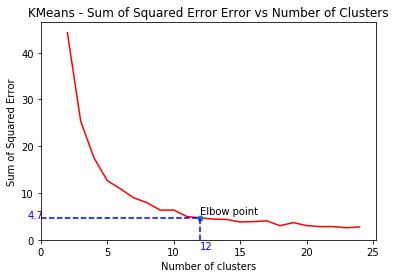

In [186]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
clus= temp.iloc[0,:]
sse = temp.iloc[1,:]
# print(sse,clus)
sns.lineplot(clus,sse,color = 'r').set_title('KMeans - Sum of Squared Error Error vs Number of Clusters')
plt.plot(12,sse[10],marker = '.',markersize = 10)
plt.plot((12,12),(0,sse[10]),'--',color ='b')
plt.plot((0,12),(sse[10],sse[10]),'--',color = 'b')
plt.text(12,5.5,"Elbow point")
plt.text(12,-2,'12',color= 'b')
plt.text(-1,sse[10],str(round(sse[10],2)),color = 'b')
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared Error")
plt.ylim(0)
plt.xlim(0)
# plt.set_xticks(range(2,25))

In [127]:
rs.createorReplaceTempView('temp')

'RDD' object has no attribute 'createorReplaceTempView'
Traceback (most recent call last):
AttributeError: 'RDD' object has no attribute 'createorReplaceTempView'



In [106]:
import pickle
with open("sse.pickle","wb") as f:
    pickle.dump(sse,f)
with open("clus.pickle","wb") as f:
    pickle.dump(clus,f)

In [107]:
import os
os.getcwd()

'/hadoop/yarn/local/usercache/tt425/appcache/application_1574881784974_0038/container_e46_1574881784974_0038_01_000001'

In [111]:
%%local
%matplotlib inline
import seaborn as sns
sns.__version__
sns.lineplot(range(0,20),rs).set_title('Mean Squared Error vs NUmber of Clusters')
plt.xlabel("Number of clusters")
plt.ylabel("Mean squared errror")


NameError: name 'rs' is not defined

In [100]:
%%sql -q -o sse
SELECT * from Temp

NameError: name 'sns' is not defined

In [18]:
monthly_means.filter(monthly_means.county_name == "Preble").show()

+-----------+-----+-------------------+
|county_name|Month|        monthly_agg|
+-----------+-----+-------------------+
|     Preble|    4|0.17120983023391814|
|     Preble|    6|0.13504294333333333|
|     Preble|    9|         0.14891958|
|     Preble|   10|0.14109571935483872|
|     Preble|   12|0.17331094193548388|
|     Preble|    2|0.19799784384236455|
|     Preble|    8|0.15245719199110122|
|     Preble|    7|0.14096112520908005|
|     Preble|    3| 0.1860423230967742|
|     Preble|    1|0.18377140967741937|
|     Preble|   11|0.15677961151515152|
|     Preble|    5|0.14755334623655916|
+-----------+-----+-------------------+

In [8]:
df = mean_df.select('state_name').distinct()
df.show(60)

+--------------------+
|          state_name|
+--------------------+
|                Utah|
|              Hawaii|
|   Country Of Mexico|
|           Minnesota|
|                Ohio|
|              Oregon|
|            Arkansas|
|District Of Columbia|
|               Texas|
|        North Dakota|
|        Pennsylvania|
|         Connecticut|
|             Vermont|
|            Nebraska|
|              Nevada|
|         Puerto Rico|
|          Washington|
|            Illinois|
|            Oklahoma|
|            Delaware|
|              Alaska|
|          New Mexico|
|       West Virginia|
|            Missouri|
|        Rhode Island|
|             Georgia|
|             Montana|
|            Michigan|
|            Virginia|
|      North Carolina|
|             Wyoming|
|              Kansas|
|          New Jersey|
|            Maryland|
|             Alabama|
|             Arizona|
|                Iowa|
|       Massachusetts|
|            Kentucky|
|           Louisiana|
|         M

In [9]:
new_york_df = mean_df.filter(mean_df.state_name == "New York")

In [11]:
new_york_df.select('county_name').distinct().show()

+-----------+
|county_name|
+-----------+
|     Monroe|
|     Queens|
|    Steuben|
|     Albany|
|       Erie|
|   New York|
|      Bronx|
+-----------+

In [12]:
new_york_df.coalesce(1).write.csv("lele.csv")

In [11]:
county_yearly = new_york_df.groupby("county_name","Year").agg((mean("arithmetic_mean").alias("Mean Yearly")))
county_yearly.show()

+-----------+----+--------------------+
|county_name|Year|         Mean Yearly|
+-----------+----+--------------------+
|      Bronx|2016|  0.3186866557377049|
|   New York|2013| 0.39732192837078667|
|     Albany|2014| 0.22749698767123275|
|     Albany|2013| 0.23328727671232874|
|     Monroe|2013| 0.19607816301369863|
|       Erie|2015| 0.27701680070175444|
|     Queens|2015|  0.2490698808219179|
|    Steuben|2016|  0.1199536454413894|
|      Bronx|2015|  0.2759923917808219|
|       Erie|2013| 0.32656941949152546|
|    Steuben|2013|  0.1388630392156864|
|     Monroe|2014|  0.1993096306068602|
|   New York|2014|   0.413923745042493|
|      Bronx|2013|  0.3927578130193905|
|   New York|2015|  0.3455472415730336|
|     Albany|2017| 0.24317862739726043|
|     Queens|2013| 0.21844274861878454|
|     Queens|2016| 0.23725369889502776|
|      Bronx|2017|7.331821917808217E-4|
|     Queens|2014|  0.2369808791208793|
+-----------+----+--------------------+
only showing top 20 rows

In [12]:
county_yearly.createOrReplaceTempView("Temp")

In [13]:
%%sql -q -o Temp
SELECT * from Temp

Text(0.5, 1.0, 'County CO concentrations in New York from 2013-2017')

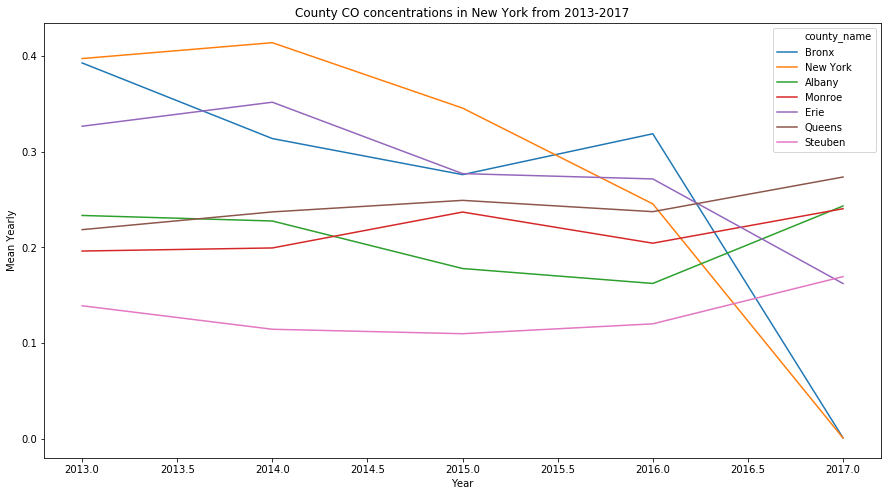

In [14]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(15,8))
sns.lineplot(x = "Year", y = "Mean Yearly", data= Temp, hue = "county_name").set_title("County CO concentrations in New York from 2013-2017")

In [15]:
#individual forecast for each county
bronx = new_york_df.filter(new_york_df.county_name == "Bronx")

In [18]:
bronx.drop("state_name","county_name")

+----+-----+---+--------+----------+-----------+-------------------+----------+-----------+
|Year|Month|day|week_num|state_code|county_code|    arithmetic_mean|state_name|county_name|
+----+-----+---+--------+----------+-----------+-------------------+----------+-----------+
|2014|    8| 10|      32|        36|          5|             0.3375|  New York|      Bronx|
|2013|    6|  7|      23|        36|          5|                0.2|  New York|      Bronx|
|2014|    7| 28|      31|        36|          5|           0.116667|  New York|      Bronx|
|2015|   10| 29|      44|        36|          5|0.13333299999999998|  New York|      Bronx|
|2015|    8|  9|      32|        36|          5|           0.120833|  New York|      Bronx|
|2017|    9|  9|      36|        36|          5|                0.0|  New York|      Bronx|
|2013|   11| 21|      47|        36|          5|              0.425|  New York|      Bronx|
|2016|    1| 18|       3|        36|          5|           0.233333|  New York| 

In [43]:
#finding the average values for 2013-2017 for each state
co_5years = co_yearly.filter(co_yearly.Year > 2012).groupBy("state_name").agg(mean("Yearly average") \
                .alias("2013-2017 average")).orderBy("2013-2017 average", ascending=False)
co_5years.show(truncate = False)

+--------------------+-------------------+
|state_name          |2013-2017 average  |
+--------------------+-------------------+
|Puerto Rico         |0.6671329960554566 |
|Country Of Mexico   |0.5653080908632506 |
|Alaska              |0.5191308316548986 |
|Georgia             |0.4268220682379    |
|Utah                |0.4190791596934188 |
|District Of Columbia|0.4115734088347929 |
|Indiana             |0.38427802081953155|
|Hawaii              |0.37943609307339543|
|Arizona             |0.3639955218849876 |
|Rhode Island        |0.358557028226732  |
|Nevada              |0.3508772720937191 |
|Colorado            |0.34905152538455214|
|Arkansas            |0.34790292263567635|
|New Jersey          |0.3438572363905138 |
|Alabama             |0.34244770057799606|
|Louisiana           |0.3414684704134087 |
|California          |0.33324452671172206|
|Washington          |0.3220576305399262 |
|Nebraska            |0.3198142049067971 |
|Michigan            |0.31347984747646396|
+----------

In [44]:
#storing the data in a temp table and storing it in a local variable
co_5years.createOrReplaceTempView("temp")

In [45]:
%%sql -q  -o temp
SELECT * from temp

An internal error was encountered.
Please file an issue at https://github.com/jupyter-incubator/sparkmagic
Error:
'LivySession' object has no attribute 'sql_context_variable_name'


###### Plotting top 10 states with highest average CO concentration from 2013-2017

Text(0.5, 1.0, 'Top 10 states with highest CO concentration from 2013-2017')

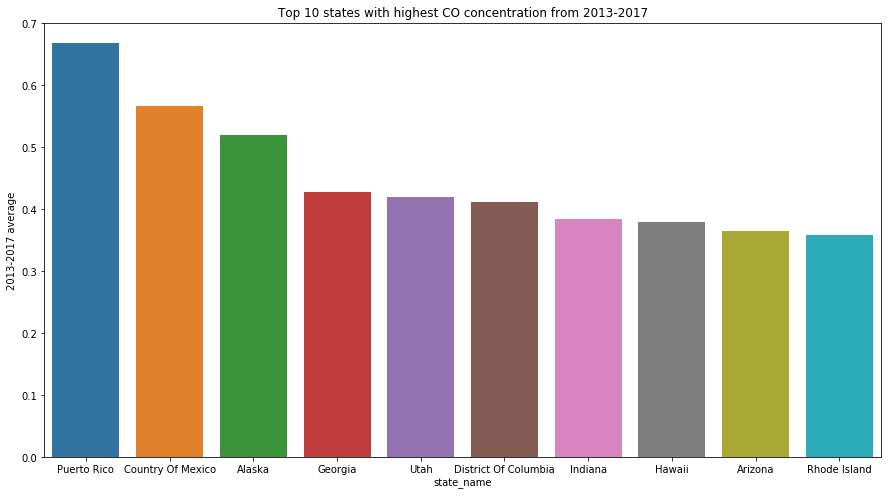

In [14]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(15,8))
sns.barplot(x = "state_name", y = "2013-2017 average", data= temp.head(10)).set_title("Top 10 states with highest CO concentration from 2013-2017")

###### Plotting top 10 states with lowest average CO concentration from 2013-2017

Text(0.5, 1.0, 'Top 10 states with lowest CO concentration from 2013-2017')

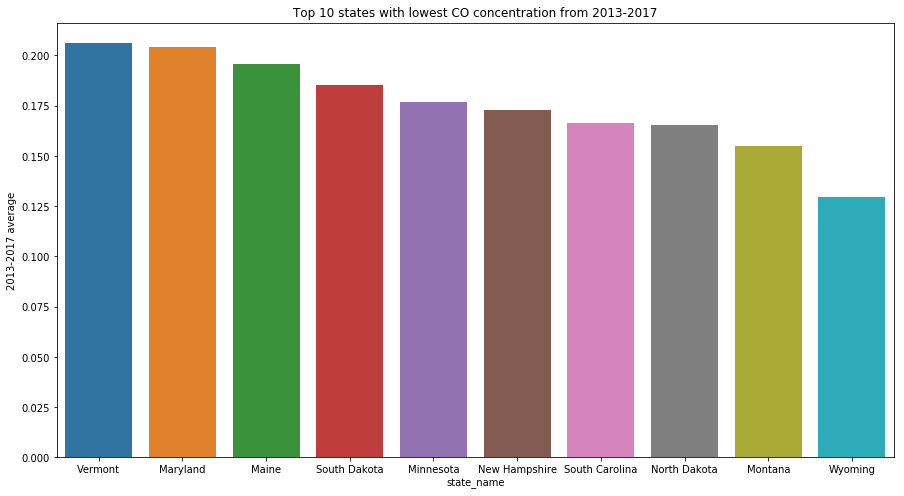

In [15]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(15,8))
sns.barplot(x = "state_name", y = "2013-2017 average", data= temp.tail(10)).set_title("Top 10 states with lowest CO concentration from 2013-2017")

###### Yearly trend in average CO concentration in the United States

In [16]:
co_avg_yearly = co_yearly.groupBy("Year").agg(mean("Yearly average").alias("Yearly average")).orderBy("Year")
co_avg_yearly.show(truncate= False)

+----+-------------------+
|Year|Yearly average     |
+----+-------------------+
|1990|1.124903556830077  |
|1991|1.0795296005169512 |
|1992|1.0526616413161318 |
|1993|1.0377559488834425 |
|1994|1.026367986813056  |
|1995|0.9559884511700127 |
|1996|0.9076586352371461 |
|1997|0.8603198903030541 |
|1998|0.8801551556837819 |
|1999|0.8267379465804363 |
|2000|0.7375895990243033 |
|2001|0.6873524498217685 |
|2002|0.6470853642647524 |
|2003|0.6194349148755856 |
|2004|0.5731445266211533 |
|2005|0.5377781885007218 |
|2006|0.5039344423449712 |
|2007|0.4502055456108371 |
|2008|0.40666073122637164|
|2009|0.3750961185403813 |
+----+-------------------+
only showing top 20 rows

In [17]:
co_avg_yearly.createOrReplaceTempView("temp")

In [18]:
%%sql -q -o temp
SELECT * from temp

Text(0.5, 1.0, 'Yearly trend in average CO concentration for United States')

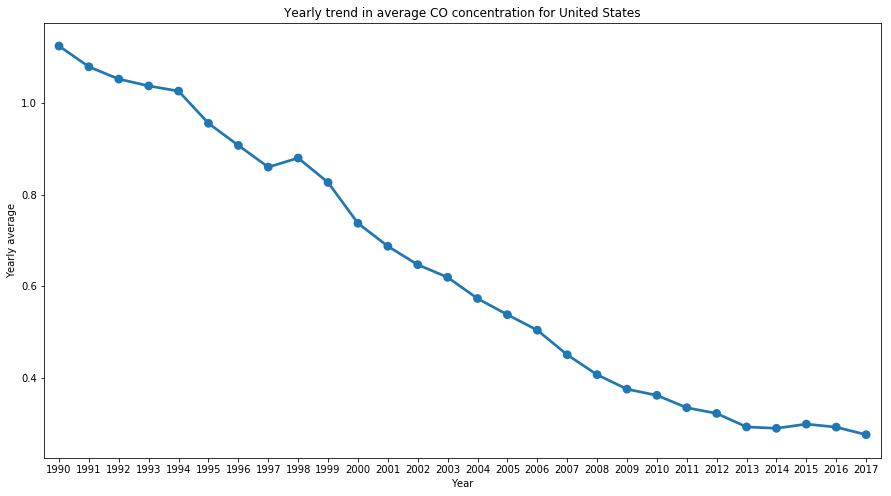

In [21]:
%%local
%matplotlib inline
plt.figure(figsize =(15,8))
sns.pointplot(x='Year', y='Yearly average', data=temp).set_title("Yearly trend in average CO concentration for United States")

##### CO concentration heatmap for all states and years greater than 2007

In [26]:
co_2007 = co_yearly.filter(co_yearly.Year > 2007)

In [27]:
co_2007.createOrReplaceTempView("temp")

In [28]:
%%sql -q -o temp
SELECT * from temp

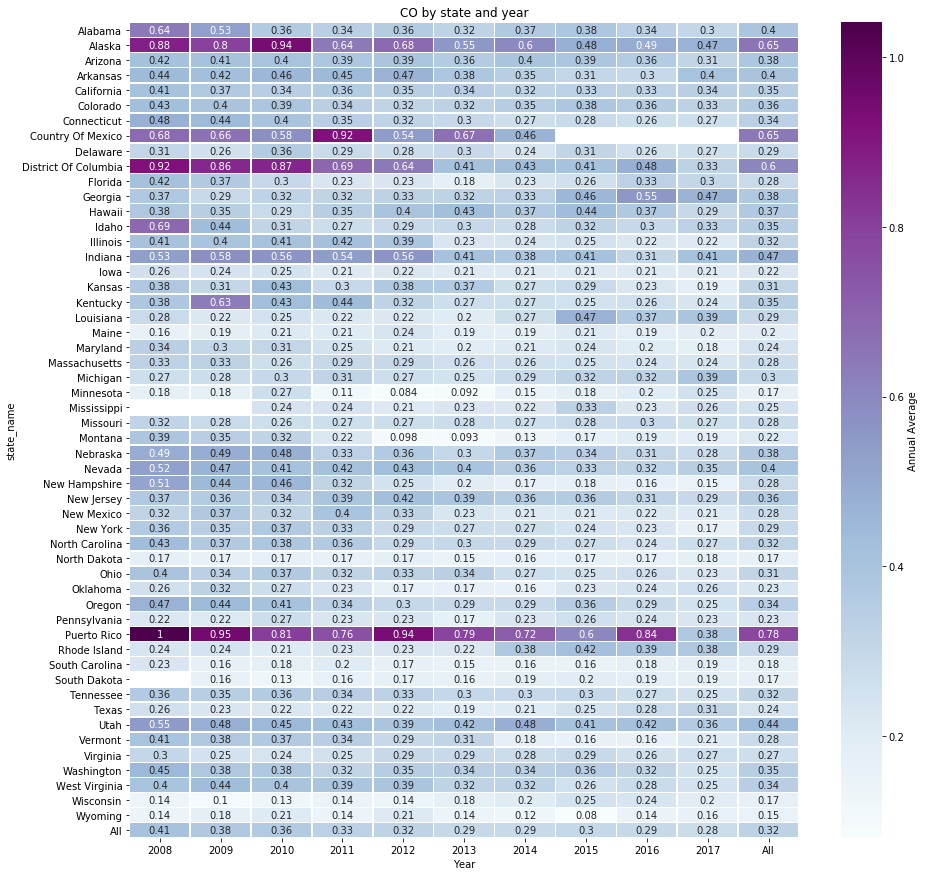

In [29]:
%%local
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('CO by state and year')
sns.heatmap(temp.pivot_table('Yearly average', index='state_name',
                columns=['Year'],margins=True),
                annot=True,cmap="BuPu", linewidths=.5, ax=ax,cbar_kws={'label': 'Annual Average'})

### O3 concentration

In [14]:
o3 = spark.read.option("inferSchema", True).csv("o3.csv",header=True,sep=",")

In [15]:
#extracting year, month and day from date
o3_modified = o3.withColumn("Year",year(o3["date_local"])).withColumn("Month",month(o3["date_local"])) \
                .withColumn("day",dayofmonth(o3["date_local"]))
o3_yearly = o3_modified.groupBy("state_name","Year").agg(mean("arithmetic_mean").alias("Yearly average")) 
o3_yearly.describe().show()

+-------+----------+------------------+--------------------+
|summary|state_name|              Year|      Yearly average|
+-------+----------+------------------+--------------------+
|  count|      1488|              1488|                1488|
|   mean|      null|2003.5040322580646| 0.03106029861273341|
| stddev|      null| 8.038323464504767| 0.00509593359208287|
|    min|   Alabama|              1990|0.002741690476190476|
|    max|   Wyoming|              2017|0.045774561643835615|
+-------+----------+------------------+--------------------+

In [ ]:
o3[[""]]

In [16]:
#finding the average values for 2013-2017 for each state
o3_5years = o3_yearly.filter(o3_yearly.Year > 2012).groupBy("state_name").agg(mean("Yearly average") \
                .alias("2013-2017 average")).orderBy("2013-2017 average", ascending=False)
o3_5years.show(truncate = False)

+--------------+--------------------+
|state_name    |2013-2017 average   |
+--------------+--------------------+
|Colorado      |0.0386207632157241  |
|Utah          |0.03853945771267046 |
|Wyoming       |0.03831322777421067 |
|Nevada        |0.0368820214004072  |
|New Mexico    |0.03616963999491358 |
|Arizona       |0.03613042818241844 |
|Connecticut   |0.03487437244250392 |
|Idaho         |0.03390227184829547 |
|Wisconsin     |0.033511241603907053|
|Missouri      |0.033152284041931976|
|Maryland      |0.03308241366573746 |
|South Dakota  |0.03293780282202792 |
|California    |0.03289742623937579 |
|Michigan      |0.032853876746605074|
|Rhode Island  |0.032773549605152226|
|Oklahoma      |0.03240060679309996 |
|Ohio          |0.03239881731803311 |
|Tennessee     |0.032293874895912275|
|North Carolina|0.032126673767881635|
|Indiana       |0.03206039728760645 |
+--------------+--------------------+
only showing top 20 rows

In [17]:
o3_5years.createOrReplaceTempView("temp")

In [18]:
%%sql -q -o temp
SELECT * from temp

###### Plotting top 10 states with highest average O3 concentration from 2013-2017

Text(0.5, 1.0, 'Top 10 states with highest O3 concentration from 2013-2017')

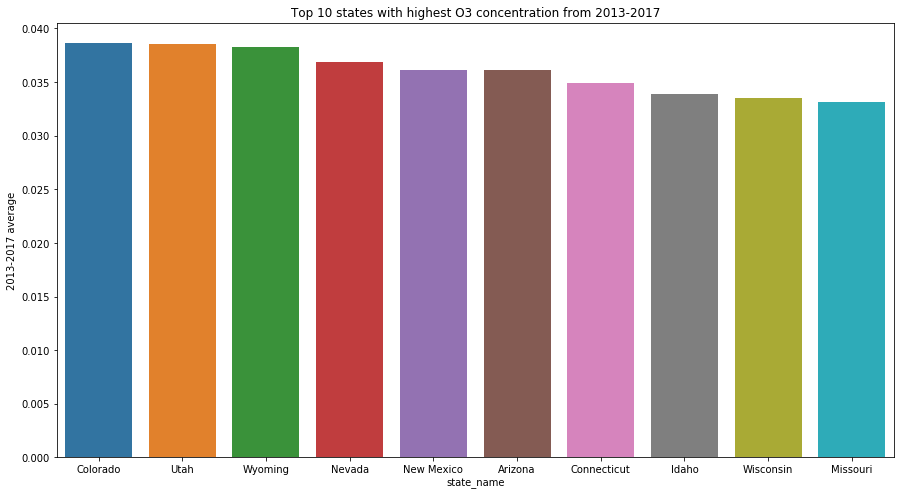

In [35]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(15,8))
sns.barplot(x = "state_name", y = "2013-2017 average", data= temp.head(10)).set_title("Top 10 states with highest O3 concentration from 2013-2017")

###### Plotting top 10 states with lowest average O3 concentration from 2013-2017

Text(0.5, 1.0, 'Top 10 states with lowest O3 concentration from 2013-2017')

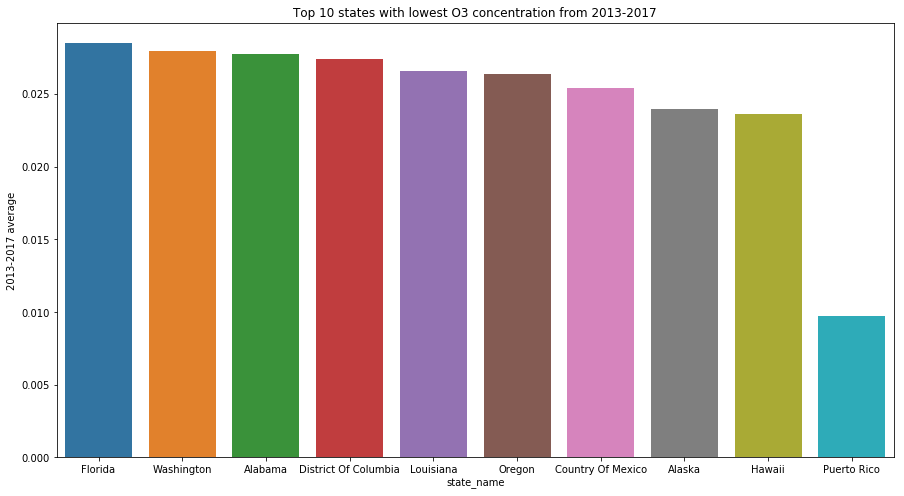

In [36]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(15,8))
sns.barplot(x = "state_name", y = "2013-2017 average", data= temp.tail(10)).set_title("Top 10 states with lowest O3 concentration from 2013-2017")

###### Yearly trend in average O3 concentration in the United States

In [38]:
o3_avg_yearly = o3_yearly.groupBy("Year").agg(mean("Yearly average").alias("Yearly average")).orderBy("Year")
o3_avg_yearly.show(truncate= False)

+----+--------------------+
|Year|Yearly average      |
+----+--------------------+
|1990|0.028045855960001052|
|1991|0.029098656277892522|
|1992|0.028025609056084404|
|1993|0.02862169987524563 |
|1994|0.030705520898992568|
|1995|0.030843090845284915|
|1996|0.0309790148286192  |
|1997|0.03111716935149885 |
|1998|0.032482783973502544|
|1999|0.03285098531051504 |
|2000|0.031069078247563366|
|2001|0.03177355443377932 |
|2002|0.03242496019533719 |
|2003|0.03178161824899533 |
|2004|0.030097760554060857|
|2005|0.03186881003948426 |
|2006|0.03215036347724708 |
|2007|0.032664475729286886|
|2008|0.03175291493417276 |
|2009|0.03020730926848156 |
+----+--------------------+
only showing top 20 rows

In [13]:
o3_avg_yearly.createOrReplaceTempView("temp")

name 'o3_avg_yearly' is not defined
Traceback (most recent call last):
NameError: name 'o3_avg_yearly' is not defined



In [40]:
%%sql -q -o temp
SELECT * from temp

Text(0.5, 1.0, 'Yearly trend in average O3 concentration for United States')

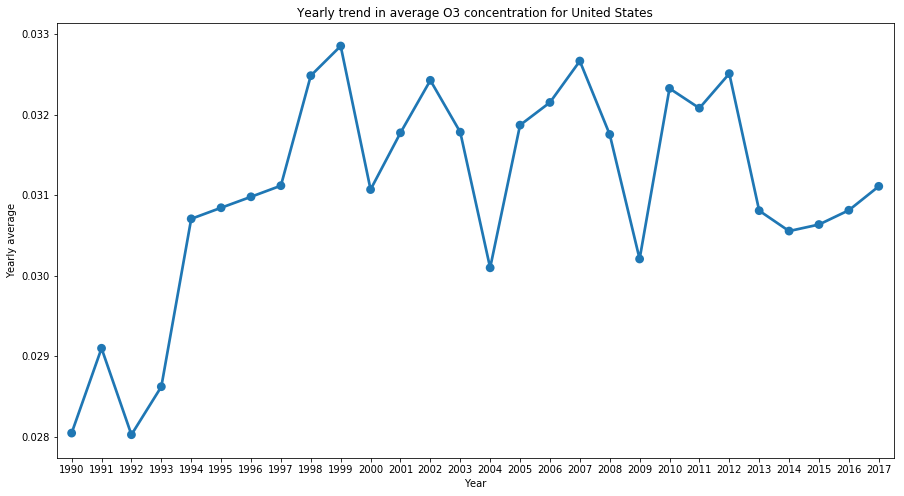

In [41]:
%%local
%matplotlib inline
plt.figure(figsize =(15,8))
sns.pointplot(x='Year', y='Yearly average', data=temp).set_title("Yearly trend in average O3 concentration for United States")

##### O3 concentration heatmap for all states and years greater than 2007

In [42]:
o3_2007 = o3_yearly.filter(o3_yearly.Year > 2007)

In [43]:
o3_2007.createOrReplaceTempView("temp")

In [44]:
%%sql -q -o temp
SELECT * from temp

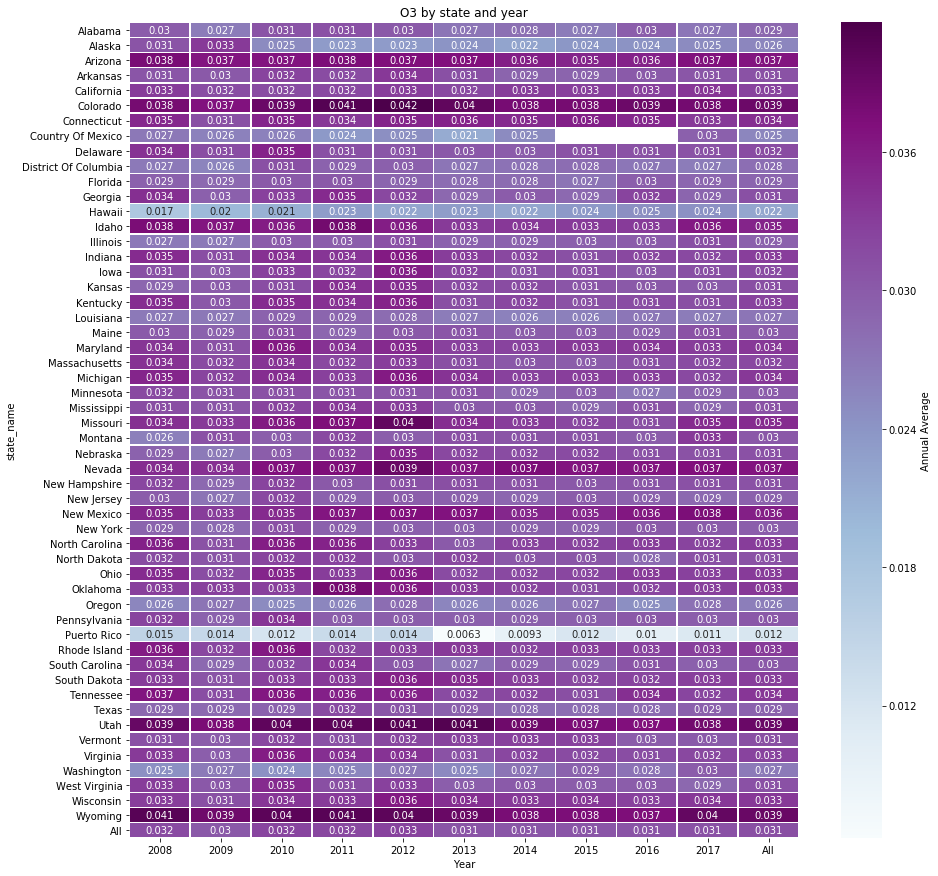

In [45]:
%%local
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('O3 by state and year')
sns.heatmap(temp.pivot_table('Yearly average', index='state_name',
                columns=['Year'],margins=True),
                annot=True,cmap="BuPu", linewidths=.5, ax=ax,cbar_kws={'label': 'Annual Average'})

### Correlation between CO, O3, NO2, SO2, PM25

In [46]:
no2 = spark.read.option("inferSchema", True).csv("no2.csv",header=True,sep=",")
pm25 = spark.read.option("inferSchema", True).csv("pm25_frm.csv",header=True,sep=",")
so = spark.read.option("inferSchema", True).csv("so2.csv",header=True,sep=",")

##### NO2 basic statistics

In [48]:
no2_modified = no2.withColumn("Year",year(no2["date_local"])).withColumn("Month",month(no2["date_local"])) \
                .withColumn("day",dayofmonth(no2["date_local"]))
no2_yearly = no2_modified.groupBy("state_name","Year").agg(mean("arithmetic_mean").alias("Yearly average")) 
no2_yearly.describe().show()

+-------+----------+------------------+------------------+
|summary|state_name|              Year|    Yearly average|
+-------+----------+------------------+------------------+
|  count|      1339|              1339|              1339|
|   mean|      null|2003.8595967139656|12.288095298899357|
| stddev|      null|7.9451409496737835| 6.103257529195332|
|    min|   Alabama|              1990|               0.0|
|    max|   Wyoming|              2017|30.579260509822706|
+-------+----------+------------------+------------------+

##### SO2 basic statistics

In [51]:
so2_modified = so.withColumn("Year",year(so["date_local"])).withColumn("Month",month(so["date_local"])) \
                .withColumn("day",dayofmonth(so["date_local"]))
so2_yearly = so2_modified.groupBy("state_name","Year").agg(mean("arithmetic_mean").alias("Yearly average")) 
so2_yearly.describe().show()

+-------+----------+------------------+--------------------+
|summary|state_name|              Year|      Yearly average|
+-------+----------+------------------+--------------------+
|  count|      1445|              1445|                1445|
|   mean|      null|2003.7010380622837|   3.493143524021012|
| stddev|      null| 8.032088021171838|   2.939047222935943|
|    min|   Alabama|              1990|0.010069073033707864|
|    max|   Wyoming|              2017|   39.49420996567507|
+-------+----------+------------------+--------------------+

##### PM 2.5 basic statistics

In [52]:
pm25_modified = pm25.withColumn("Year",year(pm25["date_local"])).withColumn("Month",month(pm25["date_local"])) \
                .withColumn("day",dayofmonth(pm25["date_local"]))
pm25_yearly = pm25_modified.groupBy("state_name","Year").agg(mean("arithmetic_mean").alias("Yearly average")) 
pm25_yearly.describe().show()

+-------+----------+------------------+------------------+
|summary|state_name|              Year|    Yearly average|
+-------+----------+------------------+------------------+
|  count|      1008|              1008|              1008|
|   mean|      null|2007.9265873015872|10.071213859181526|
| stddev|      null| 5.535707637419844| 3.165467432293596|
|    min|   Alabama|              1997|2.6727272727272724|
|    max|   Wyoming|              2017| 44.04347826086956|
+-------+----------+------------------+------------------+

In [66]:
no2_changed = no2_yearly.select(col("state_name").alias("state_name"),col("Year").alias("Year"),col("Yearly average").alias("no2"))
so2_changed = so2_yearly.select(col("state_name").alias("state_name"),col("Year").alias("Year"),col("Yearly average").alias("so2"))
o3_changed = o3_yearly.select(col("state_name").alias("state_name"),col("Year").alias("Year"),col("Yearly average").alias("o3"))
pm25_changed = pm25_yearly.select(col("state_name").alias("state_name"),col("Year").alias("Year"),col("Yearly average").alias("pm25"))
co_changed = co_yearly.select(col("state_name").alias("state_name"),col("Year").alias("Year"),col("Yearly average").alias("co"))

In [67]:
# joining statewise yearly averages of no2,so2,o3,pm25 and co
joined  = no2_changed.join(so2_changed,['state_name','Year']).join(o3_changed,['state_name','Year']).join(pm25_changed,['state_name','Year']).join(co_changed,['state_name','Year'])

In [102]:
joined.collect()

In [72]:
#correlation matrix for these five pollutants
cols = ["no2","so2","o3","pm25","co"]
joined_values = joined.select(cols)
from pyspark.mllib.stat import Statistics
features = joined_values.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")

In [80]:
rdd1 = sc.parallelize(corr_mat)
# rdd1.collect()
rdd2 = rdd1.map(lambda x: [float(i) for i in x])
df = rdd2.toDF(["no2","so2","o3","pm25","co"])
df.show()

+-------------------+--------------------+--------------------+-------------------+-------------------+
|                no2|                 so2|                  o3|               pm25|                 co|
+-------------------+--------------------+--------------------+-------------------+-------------------+
|                1.0|  0.3162447376338811| 0.15486350621992837| 0.5237318397814424| 0.4916874087945782|
| 0.3162447376338811|                 1.0|-0.13694813038946227| 0.3872055511420079|0.38375713559558317|
|0.15486350621992837|-0.13694813038946227|                 1.0|0.14951515988722874|-0.1835426848002621|
| 0.5237318397814424|  0.3872055511420079| 0.14951515988722874|                1.0|0.34439864981950574|
| 0.4916874087945782| 0.38375713559558317| -0.1835426848002621|0.34439864981950574|                1.0|
+-------------------+--------------------+--------------------+-------------------+-------------------+

In [81]:
df.createOrReplaceTempView("temp")

In [93]:
%%sql -q -o temp
SELECT * from temp

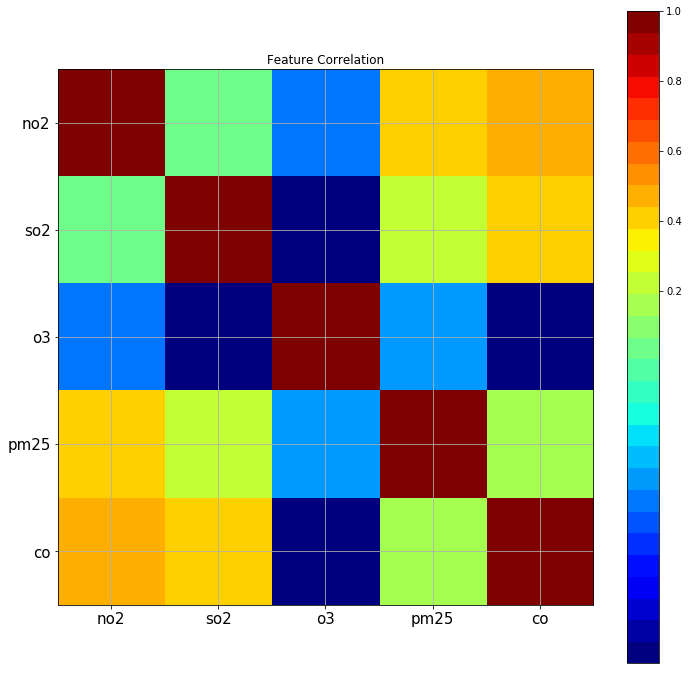

In [100]:
%%local
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Feature Correlation')
    labels=[" ","no2","so2","o3","pm25","co"]
    ax1.set_xticklabels(labels,fontsize=15)
    ax1.set_yticklabels(labels,fontsize=15)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.2,.4,.6,.8,1])
    plt.show()

correlation_matrix(temp)

##### Future Steps
1. Perform clustering for states using annual average concentration levels as features to find similar states
2. Create a machine learning model to predict concentration of various pollutants using time series forecasting in Spark.
